# MA 346 Final Project: Logistic Regression - Predicting Titanic Survival

### By Carly Drischler

## Data Background and Goals

The dataset used for this project comes from Kaggle, an online data science community that enables their users to upload, download, and explore datasets, build models, work with others in the community, and even enter competitions. 

In particular, my dataset includes information regarding the passengers of the maiden voyage of the Titanic. This data includes information regarding the passengers age, gender, fare amount, whether or not they survived the wreckage, and more. The goal of this project is to build a model that is good at predicting whether or not an individual with particular characteristics would have survived. It is important to note that I ran multiple logistic regression models and analyzed their results. Keeping this in mind, I will be showing the best model I found, and comparing it to a much poorer one.

Link to the dataset used for this project: https://www.kaggle.com/datasets/yasserh/titanic-dataset


## Getting Our Data Ready

First, let us import the necessary modules for coding.

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns

Success! No output means no errors.

Let's read in our data set and take a look at the first few rows. 

In [2]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Even from first glance, we can identify some issues with our data. For instance, we can see that a few columns, such as 'PassenderId' and 'Name' consist of unique or nearly unique data that add minimal value to our future analyses. 

So, let's clean up the data a bit. To do this, we will remove these unique columns, remove any rows with missing data (to enable our regression analysis), and convert appropriate columns to integer values.

In [3]:
# Drop unique or nearly unique columns
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Convert sex column to boolean for female (1) or male (0)
df['is_female'] = np.where(df['Sex'] == 'female', 1, 0)
df = df.drop('Sex', axis=1)

# Must drop NaNs in order for regression to work
df = df.dropna()

# Round numeric values to nearest whole number to allow for integer datatype
df = df.round(0)
df['Age'] = df['Age'].astype(int)
df['Fare'] = df['Fare'].astype(int)

# Drop column (played with it, not really useful for analysis, not worth it to convert)
df = df.drop('Embarked', axis=1)

df

,Survived,Pclass,Age,SibSp,Parch,Fare,is_female
0,0,3,22,1,0,7,0
1,1,1,38,1,0,71,1
2,1,3,26,0,0,8,1
3,1,1,35,1,0,53,1
4,0,3,35,0,0,8,0
...,...,...,...,...,...,...,...
885,0,3,39,0,5,29,1
886,0,2,27,0,0,13,0
887,1,1,19,0,0,30,1
889,1,1,26,0,0,30,0


You may now explore our cleaned data set. 

## Training and Validation Split

In order to create a model that works well using unseen data (data that wasn't used to create the model), we should split our dataset into two parts, one to create the model, the other to test the model. To acccomplish this, let us use a random sample of 80% of our dataset to create the model and use the remaining 20% to test the model.

In [4]:
seed          = 25
df_training   = df.sample( frac=0.8, random_state=seed )
df_validation = df.drop( df_training.index )

Success! No output means no errors.

## General Model Functions

Now, let us define two functions. First, we will define the 'fit_model_to' function to fit a logistic regression model to our training data on provided predictors. Additionally, this function fits a separate model to the standardized predictors so that we may look at this model's coefficients and compare amongst predictors. Second, we will define the 'score_model' function to return the F1 score for the model, when tested on the validation data. 

This F1 score is a way of measuring model success in that it is a balanced measure (geometric mean) of the models precision and recall, which represent the probablity that the result is a true positive given that the test said positive, and the probability that the test would detect a positive result given it is truly positive, respectively.


In [5]:
def fit_model_to ( training ):
    # All but response column
    predictors = training.iloc[:,1:]
    response = training['Survived']
    model = LogisticRegression()
    model.fit( predictors.values, response )

    # fit another model to standardized predictors
    standardized = ( predictors - predictors.mean() ) / predictors.std()
    temp_model = LogisticRegression()
    temp_model.fit( standardized.values, response )

    # get that model's coefficients and display them
    coeffs = pd.Series( temp_model.coef_[0], index=predictors.columns )
    sorted = np.abs( coeffs ).sort_values( ascending=False )  
    coeffs = coeffs.loc[sorted.index]                         
    print( coeffs )

    # return the model fit to the actual predictors
    return model

def score_model ( M, validation ):
    predictions = M.predict( validation.iloc[:,:-1].values )
    TP = ( validation['Survived'] & predictions ).sum()
    FP = ( ~validation['Survived'] & predictions ).sum()
    FN = ( validation['Survived'] & ~predictions ).sum()
    precision = TP / ( TP + FP )
    recall = TP / ( TP + FN )
    return 2 * precision * recall / ( precision + recall )

Success! No output means no errors.

## Model #1

The first model we will run is a logistic regression model predicting whether or not an individual survived based on the 'SibSp' and 'Parch' variables, which (according to the data dictionary on Kaggle) represent the individual's number of siblings/spouses and the number of parents/children aboard the Titanic, respectively. To do this, we will use the functions defined in the previous section using the training data consisting of our desired predictors and response columns.

In [6]:
columns = [0, 3, 4]
df_training.columns[columns]

model = fit_model_to( df_training.iloc[:,columns] )
score_model( model, df_training.iloc[:,columns] ), score_model( model, df_validation.iloc[:,columns] )

Parch    0.203597
SibSp   -0.112333
dtype: float64


(0.03676470588235294, 0.06153846153846154)

Our coefficients indicate that having a greater number of parents or children aboard the Titanic with you positively impacted your chance of survival. On the other hand, these results indicate that having a greater number of siblings or spouses aboard the Titanic with you negatively impacted your chance of survival. 

However, the F1 values for both the training data itself as well as the validation data are very poor. Let's take a look at a different model. 

## Model #2

The second model we will run is a logistic regression model predicting whether or not an individual survived based on the 'is_female', 'Age', and 'PClass' variables, which represent the sex of the passenger (1 for female, 0 for male), the age of the passenger rounded to nearest whole year, and the ticket class of the passenger (1 = First, 2 = Second, 3 = Third), respectively. Just like for model 1, we will use the functions defined in the earlier section using the training data consisting of our desired predictors and response columns.

In [7]:
columns = [0, 1, 2, 6]
df_training.columns[columns]

model = fit_model_to( df_training.iloc[:,columns] )
score_model( model, df_training.iloc[:,columns] ), score_model( model, df_validation.iloc[:,columns] )

is_female    1.186353
Pclass      -1.126648
Age         -0.567376
dtype: float64


(0.5838509316770186, 0.5435897435897437)

Our coefficients indicate that being a female positively impacted your chance of survival versus being a male. On the other hand, these results indicate that being a lower class (higher numerically, i.e. third class lower than first class) and being older negatively impacted your chance of survival.

Notice that the F1 values are MUCH higher, meaning much better than our first model. From here on, we will be using the predictors of this model in discussion.

## Discussion of Better Model

Considering our model of predicting survival using sex, age, and ticket class predictors using the training data did the best amongst experimentation, let us execute logistic regression again using our training data and the same predictors using a different Python library known as pandas. These new results will give us our estimation equation for predicting an individual's probability for survival. 

In [8]:
m2_x = df_training[['Pclass', 'Age', 'is_female']]
y = df_training['Survived']

m2_summary = pg.logistic_regression(m2_x, y, remove_na=True)
m2_summary.round(4)

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,2.8480,0.5158,5.5216,0.0,1.8371,3.8590
1,Pclass,-1.3842,0.1596,-8.6724,0.0,-1.6970,-1.0714
2,Age,-0.0405,0.0086,-4.6896,0.0,-0.0574,-0.0236
3,is_female,2.4938,0.2342,10.6466,0.0,2.0347,2.9529


Please note that the intercept and coefficients represent log-odds. For instance, the age coefficent of -0.0405 means that for every increase in one year of age, your odds of survival are multiplied by 0.9603 (see calculation below). This aligns with what was mentioned before in that being an older passenger on the Titanic negatively impacted their chance of survival.

In [9]:
np.exp(-0.0405)

0.960309164511413

To visualize this further, let's plot the simple logistic regression line for age prediciting survival.

<AxesSubplot:xlabel='Age', ylabel='Survived'>

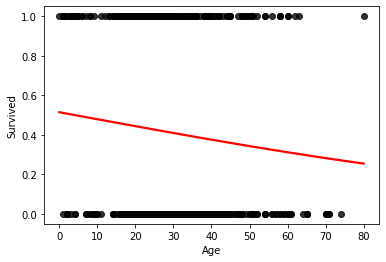

In [10]:
x = df_training['Age']
y = df_training['Survived']

sns.regplot(x=x, y=y, data=df_training, logistic=True, ci=None,
            scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

Again, we can see that as age increases, a passenger's likelihood of survival decreases.

That said, using the logistic model we produced using Pingoin, our equation for predicting an individuals probability of survival is as follows:

(1 / (1 + np.exp(-(2.848 +  (-1.3842 * Pclass) + (-0.0405 * age) + (2.4938 * is_female))))) * 100

For instance, let us calculate the odds of survival for a 21 year old male in first class:

In [11]:
(1 / (1 + np.exp(-(2.848 + (-1.3842 * 1) + (-0.0405 * 21) + (2.4938 * 0))))) * 100

64.86932086824051

According to our model, a 21 year old male in first class had approximately a 64.87% chance of surviving the wreck of the Titanic. Please visit LINK to discover likelihoods for individuals with different demographics. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a75109f5-32ac-4a65-be21-b78b560cfd1f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>